### Inits

In [2]:
import sys
sys.path.append("..")

In [3]:
# import pylab
from pylab import *

#Matplotlib defs
import matplotlib
matplotlib.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#Numpy
import numpy as np
from numpy.random import multivariate_normal


from scipy import stats
from scipy import stats
import scipy.integrate as integrate
from scipy.interpolate import interp1d as int1d
from scipy.special import erfc as erfc
from scipy.signal import savgol_filter
from scipy.spatial.distance import cdist



import random

import seaborn as sns

from tqdm.notebook import *

import arviz as az

#Astropy
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
from astropy.coordinates import SkyCoord
from astropy.coordinates import CartesianRepresentation
import astropy.units as u
from astropy.io import fits
from astropy import constants as const

#GetDist
from getdist import plots, MCSamples
import getdist

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Data Read

In [5]:
hdul = fits.open('../data/DR7.fits')
data = hdul[1].data  # First extension is the table!
ra = data['RA']
dec = data['DEC']
z = data['REDSHIFT']
mass = data['LOGBH']
dmass = data['LOGBH_ERR']


#define restricted parameters and indicators
m_min=9
m_max=13
z_max=2.5
z_min=0.4
ra_min=120
ra_max=240
dec_min=10
dec_max=50

inds=(mass<m_max) & (mass>m_min) & (z < z_max) & (dec > dec_min) & (dec < dec_max) & (ra > ra_min) & (ra < ra_max) & (z > z_min) 

# restricted arrays
z_new=z[inds]
dec_new=dec[inds]
ra_new=ra[inds]
mass_new=mass[inds]
dmass_new=dmass[inds]
DC_new=cosmo.comoving_distance(z_new)
DA_new=cosmo.angular_diameter_distance(z_new)
QSO_coord = SkyCoord(ra_new*u.degree, dec_new*u.degree, frame='icrs', distance = DC_new)



# Duty-cycle digitized
lam06=np.loadtxt(open('../../digi/lam06.csv'), delimiter=",")
lam03=np.loadtxt(open('../../digi/lam03.csv'), delimiter=",")
minL=np.loadtxt(open('../../digi/minL.csv'), delimiter=",")
lam03=np.vstack((lam03,[lam03[-1,0]+5,lam03[-1,1]]))
lam06=np.vstack((lam06,[lam06[-1,0]+5,lam06[-1,1]]))
minL=np.vstack((minL,[minL[-1,0]+5,minL[-1,1]]))
intlam06=int1d(lam06[:,0]-0.02,10**lam06[:,1],kind=1)
intlam03=int1d(lam03[:,0]-0.01,10**lam03[:,1],kind=1)
intminL=int1d(minL[:,0],10**minL[:,1],kind=1)

lamlis=intminL(mass_new)
# lamlis=intlam06(mass_new)

### Functions and constants

In [6]:
theta_BH_const=(5*const.G*const.M_sun*u.rad/(const.c)**2).to(u.microarcsecond*u.Mpc)
def theta_BH(logM,DA):
    return theta_BH_const*10**logM/DA

# M_sig relation from Ho & Kormendy 2013 in units of km/sec

def MBH_to_sig(logM):
    return (10**(logM-9)/0.31)**(1/4.38)*200
grav_BH_const=(const.G*const.M_sun*u.rad/(u.km/u.s)**2).to(u.arcsecond*u.Mpc)
def grav_BH(logM,DA):
    return grav_BH_const*10**logM/DA/(MBH_to_sig(logM))**2

#Co-moving to Angular Diameter distance
cmd_to_add=int1d(logspace(-2,4.1,200),cosmo.angular_diameter_distance(np.array([z_at_value(cosmo.comoving_distance,x*u.Mpc) for x in logspace(-2,4.1,200)])).value)

In [7]:
lis=np.linspace(0,4,1000)
DA_max=np.max(cosmo.angular_diameter_distance(lis)).value #Mpc
lis=lis[:np.argmax(cosmo.angular_diameter_distance(lis))]
DAt_lis=cosmo.angular_diameter_distance(lis).value
DCt_lis=cosmo.comoving_distance(lis)
DCt_lis=np.append(DCt_lis,cosmo.comoving_distance(lis[-1])).value
DAt_lis=np.append(DAt_lis,DA_max)
add_to_cmd=int1d(DAt_lis,DCt_lis)


### Restricted region as a function of max distance

In [8]:
def dist_from_RA(RA,ra,dec):
    theta_p=0.0174533*dec
    phi_p=0.0174533*ra
    phi=0.0174533*RA
    return np.sin(theta_p)*np.abs(np.sin(phi-phi_p))

def dist_from_DEC(DEC,dec):
    theta_p=0.0174533*dec
    theta=0.0174533*DEC
    return np.abs(np.sin(theta-theta_p))

def Is_In_rage(ra,dec,rp,rmax):
    x=rmax/rp.value
    return (dist_from_DEC(dec_min,dec)>x) & (dist_from_DEC(dec_max,dec)>x) & (dist_from_RA(ra_max,ra,dec)>x)& (dist_from_RA(ra_min,ra,dec)>x)


Rmax=cosmo.comoving_distance(z_max)
Rmin=cosmo.comoving_distance(z_min)
def Is_In_rage_Mpc(ra,dec,rp,rmax):
    RMMpc=Rmax.value
    RmMpc=Rmin.value
    x=rmax/rp
    return (rp>RmMpc+rmax) & (rp<RMMpc-rmax) & (dist_from_DEC(dec_min,dec)>x) & (dist_from_DEC(dec_max,dec)>x) & (dist_from_RA(ra_max,ra,dec)>x)& (dist_from_RA(ra_min,ra,dec)>x)

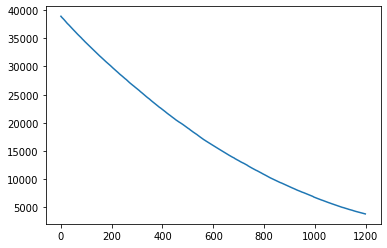

In [8]:
# res_arr=np.array([])
plt.plot(range(0,1200),np.array([np.sum(Is_In_rage(ra_new,dec_new,DC_new,dis)) for dis in range(0,1200)]))
plt.show()

Let us calcualte the volume of the region that is $r_{\rm max}$ away from the region bounded by $[R_{\rm min},R_{\rm max},\theta_{\rm min},\theta_{\rm max},\phi_{\rm min},\phi_{\rm max}]$. 

Ok.. This is complicated.. MC it is.

In [9]:
def z_ran_max(rmax):
    return z_at_value(cosmo.comoving_distance,cosmo.comoving_distance(z_max)-rmax*u.Mpc)
def z_ran_min(rmax):
    return z_at_value(cosmo.comoving_distance,cosmo.comoving_distance(z_min)+rmax*u.Mpc)

In [10]:
npoints=300
# r_max=700 #Mpc


rand_ra=ra_min+(ra_max-ra_min)*(np.random.random_sample((npoints)))
rand_dec=dec_min+(dec_max-dec_min)*(np.random.random_sample((npoints)))
rand_z=z_min+(z_max-z_min)*(np.random.random_sample((npoints)))
rand_dis=cosmo.comoving_distance(rand_z).value


In [11]:
def dis_from_walls(ra,dec,rp):
    RMMpc=Rmax.value
    RmMpc=Rmin.value
    dra1=rp*dist_from_DEC(dec_min,dec)
    dra2=rp*dist_from_DEC(dec_max,dec)
    ddec1=rp*dist_from_RA(ra_min,ra,dec)
    ddec2=rp*dist_from_RA(ra_max,ra,dec)
    dr1=rp-RmMpc
    dr2=RMMpc-rp
    return np.array([dra1,dra2,ddec1,ddec2,dr1,dr2]).min(axis=0)

# big_arr=np.array([dis_from_walls(RA,DEC,DIS) for RA in tqdm(rand_ra) for DEC in rand_dec for DIS in rand_dis])

In [12]:
#A function that gets a cartesian coardinate and returns its distance from the boundary.

def car_dis_wall(x,y,z):
    deg_to_rad=np.pi/180
    
    phi_min=deg_to_rad*ra_min
    phi_max=deg_to_rad*ra_max
    
    theta_min=deg_to_rad*dec_min
    theta_max=deg_to_rad*dec_max
    
    RMMpc=Rmax.value
    RmMpc=Rmin.value
    
    rho=np.sqrt(x**2+y**2)
    r=np.sqrt(rho**2+z**2)
    
    
    Dphi_min= -(x*np.sin(phi_min) -y*np.cos(phi_min))
    Dphi_max= x*np.sin(phi_max) -y*np.cos(phi_max)

    Dtheta_min= -(z*np.sin(theta_min) -rho*np.cos(theta_min))
    Dtheta_max= z*np.sin(theta_max) -rho*np.cos(theta_max)
    
    return np.array([Dphi_min,Dphi_max,Dtheta_min,Dtheta_max,r-RmMpc,RMMpc-r]).min(axis=0)

In [13]:
long_pts_lis=np.loadtxt(open('../data/Long_Car_lis.csv'), delimiter=",");
#Data from mathematica that was over written since. Cartesian cooardinates of many random observers.

In [14]:
dis_from_walls=car_dis_wall(long_pts_lis[:,0],long_pts_lis[:,1],long_pts_lis[:,2])
np.sum(dis_from_walls>1000)

Obs_lis=long_pts_lis[dis_from_walls>1000][:40000]

In [15]:
Obs_lis.shape

(40000, 3)

In [31]:
np.savetxt('../data/Long_Car_lis.csv',long_pts_lis[dis_from_walls>0], delimiter=",")
np.savetxt('../data/Long_Car_lis_500.csv',long_pts_lis[dis_from_walls>500], delimiter=",")
np.savetxt('../data/Long_Car_lis_700.csv',long_pts_lis[dis_from_walls>700], delimiter=",")
np.savetxt('../data/Long_Car_lis_1000.csv',long_pts_lis[dis_from_walls>1000], delimiter=",")

In [16]:
#Make cartsian
def Rvec(r,q,f):
    X=r*np.sin(q)*np.cos(f)
    Y=r*np.sin(q)*np.sin(f)
    Z=r*np.cos(q)
    return np.transpose(np.array([X,Y,Z]))





QSO_car=Rvec(DC_new.value,dec_new*np.pi/180,ra_new*np.pi/180)

In [24]:
QO_dsit=cdist(Obs_lis,QSO_car)
QO_dsit.shape

(40000, 38928)

In [17]:
np.savetxt('../data/QO_dist_1000.csv',QO_dsit, delimiter=",")

KeyboardInterrupt: 

In [31]:
mass_obs=np.array([mass_new[x<1000] for x in tqdm(QO_dsit)])
dmass_obs=np.array([dmass_new[x<1000] for x in tqdm(QO_dsit)])

(4476,)

In [64]:
big_arr=np.array([[RA,DEC,DIS] for RA in tqdm(rand_ra) for DEC in rand_dec for DIS in rand_dis])


# np.array([np.sum(Is_In_rage(rand_ra,rand_dec,rand_dis,rm)) for rm in range(0,1200)]).size
big_arr[:,0].size

27000000

In [65]:
big_dis_arr=np.sort(dis_from_walls(big_arr[:,0],big_arr[:,1],big_arr[:,2]))


inMC=int1d(big_dis_arr,npoints**3-np.arange(npoints**3),fill_value="extrapulate")
vol_arr=inMC(range(4,1200))
# np.array([big_dis_arr[big_dis_arr<dis].shape[0] for dis in trange(0,1200)])

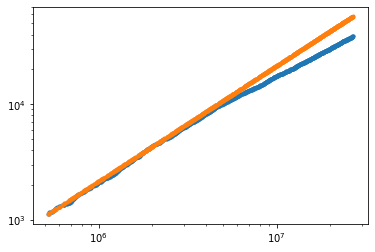

In [66]:
# vol_arr5=np.array([np.sum(Is_In_rage_Mpc(big_arr[:,0],big_arr[:,1],big_arr[:,2],rm)) for rm in range(0,1200)])/npoints**3
N_arr=np.array([np.sum(Is_In_rage_Mpc(ra_new,dec_new,DC_new.value,dis)) for dis in range(4,1200)])

plt.loglog(vol_arr,N_arr,'.')
plt.loglog(vol_arr,N_arr[-10]*vol_arr/vol_arr[-10],'.')
plt.show()

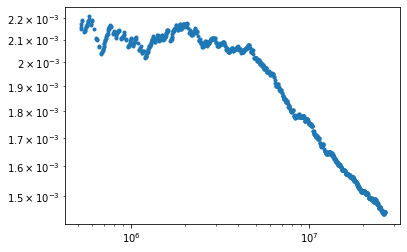

In [68]:
# plt.loglog(range(0,1200)[:800],(vol_arr[-1]*N_arr/vol_arr/N_arr[-1])[:800],'.')

# plt.loglog(vol_arr,N_arr/vol_arr/np.mean((N_arr/vol_arr)[vol_arr<0.1]))
# plt.loglog(vol_arr2,N_arr/vol_arr2/np.mean((N_arr/vol_arr2)[vol_arr2<0.1]))
# plt.loglog(vol_arr3,N_arr/vol_arr3/np.mean((N_arr/vol_arr3)[vol_arr3<0.1]))
# plt.loglog(vol_arr4,N_arr/vol_arr4/np.mean((N_arr/vol_arr4)[vol_arr4<0.1]))
# plt.loglog(vol_arr,0*vol_arr+1)
# plt.show()


plt.loglog(vol_arr,N_arr/vol_arr,'.')
# plt.plot(vol_arr2,N_arr/vol_arr2,'.')
# plt.plot(vol_arr3,N_arr/vol_arr3,'.')
# plt.plot(vol_arr4,N_arr/vol_arr4,'.')
# plt.plot(vol_arr5,N_arr/vol_arr5,'.')
# plt.loglog(vol_arr,0*vol_arr+1)
plt.show()

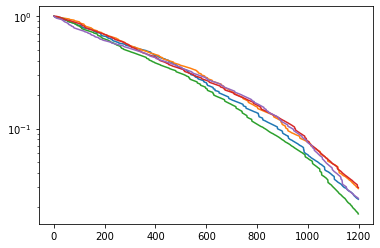

In [129]:
plt.semilogy(vol_arr)
plt.plot(vol_arr2)
plt.plot(vol_arr3)
plt.plot(vol_arr4)
plt.plot(vol_arr5)
plt.show()

# Random Arrays

# Import random crap

In [12]:
r_max=700 #Mpc
z_rmax=z_at_value(cosmo.comoving_distance,r_max*u.Mpc)

ran_dist_lis=np.loadtxt('./data/ran_dist_700.csv',delimiter=',')
ran_dec_lis=np.loadtxt('./data/ran_dec_700.csv',delimiter=',')
ran_ra_lis=np.loadtxt('./data/ran_ra_700.csv',delimiter=',')

# rand_cords=np.array([SkyCoord(ran_ra_lis[i]*u.degree, ran_dec_lis[i]*u.degree, frame='icrs', distance = x*u.Mpc) for i,x in enumerate(tqdm(ran_dist_lis[:200000]))])

OSError: ./data/ran_dist_700.csv not found.

In [7]:
# [QSO_coord[1],(QSO_coord[2])]
def Rvec(r,q,f):
    X=r*np.sin(q)*np.cos(f)
    Y=r*np.sin(q)*np.sin(f)
    Z=r*np.cos(q)
    return np.transpose(np.array([X,Y,Z]))





QSO_car=Rvec(DC_new.value,dec_new*np.pi/180,ra_new*np.pi/180)
OBS_car=Rvec(ran_dist_lis,ran_dec_lis*np.pi/180,ran_ra_lis*np.pi/180)[:25000]

In [8]:
np.savetxt('./data/QSO_x.csv',QSO_car[:,0])
np.savetxt('./data/QSO_y.csv',QSO_car[:,1])
np.savetxt('./data/QSO_z.csv',QSO_car[:,2])

In [9]:
# ran_ball_100Mpc=np.loadtxt('./data/ran_ball_100.csv',delimiter=',');
# ran_ball_car=Rvec(ran_ball_100Mpc[:,0],ran_ball_100Mpc[:,1]*np.pi/180,ran_ball_100Mpc[:,2]*np.pi/180);
# ran_ball_pos=np.loadtxt('./data/ran_ball_pos.csv',delimiter=',')
# OBS_ball_arr=np.array([ran_ball_car+x for x in ran_ball_pos])
OBS_ball_long=np.loadtxt('./data/ball_100_car.csv',delimiter=',')

In [10]:
from scipy.spatial.distance import cdist

rand_dist=cdist(OBS_car,QSO_car)
# rand_dist=cdist(OBS_ball_long,QSO_car)

# rand_dist=np.array([(x.separation_3d(QSO_coord).value) for x in tqdm(rand_cords)])



In [11]:
# A boolean array that tells you when a rnadom point and a quasrs are less than r_max appart.
rand_N=len(rand_dist[:,1])

dist_bool=np.array([rand_dist[i,:]<r_max for i in trange(rand_N)])

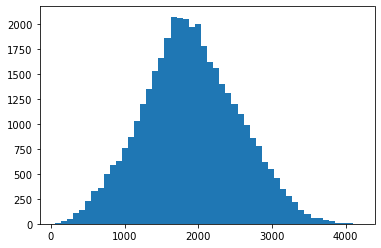

In [12]:
# rand_dist.shape
plt.hist(rand_dist[250],bins=50)
plt.show()

# Statistics - shadow

### A smarter statistics

In [13]:
vol_max=4*np.pi*(r_max**3)/3
mass_bins=np.linspace(8,12,40)
dbins=mass_bins[1]-mass_bins[0]
rand_mass=np.array([np.random.normal(mass_new[dist_bool[i]], dmass_new[dist_bool[i]]) for i in trange(rand_N, leave=True)])
rand_theta=np.array([theta_BH(x,cmd_to_add(rand_dist[i][dist_bool[i]])*u.Mpc).value for i, x in enumerate(tqdm(rand_mass, leave=True))])

# hist_mass=0*np.array([np.histogram(x,bins=mass_bins,density=True)[0]*len(x)/vol_max for i,x in enumerate(tqdm(rand_mass, leave=True))])
hist_theta_p1=np.array([np.histogram(x[rand_theta[i]>0.1],bins=mass_bins,density=True)[0]*len(x[rand_theta[i]>0.1]) for i,x in enumerate(tqdm(rand_mass, leave=True))])
hist_theta_p01=np.array([np.histogram(x[rand_theta[i]>.5],bins=mass_bins,density=True)[0]*len(x[rand_theta[i]>.5]) for i,x in enumerate(tqdm(rand_mass, leave=True))])
hist_theta_p05=np.array([np.histogram(x[rand_theta[i]>.05],bins=mass_bins,density=True)[0]*len(x[rand_theta[i]>.05]) for i,x in enumerate(tqdm(rand_mass, leave=True))])
hist_theta_1=np.array([np.histogram(x[rand_theta[i]>1],bins=mass_bins,density=True)[0]*len(x[rand_theta[i]>1]) for i,x in enumerate(tqdm(rand_mass, leave=True))])
# hist_theta_10=np.array([np.histogram(x[rand_theta[i]>10],bins=mass_bins,density=True)[0]*len(x[rand_theta[i]>10]) for i,x in enumerate(tqdm(rand_mass, leave=True))])
cord_mass=(mass_bins[1:]+mass_bins[:-1])/2

In [14]:
dN_1_dlogM_med=np.array([np.median(x) for x in (np.transpose(hist_theta_1))])
dN_1_dlogM_90CL=np.array([az.hdi(x,0.9) for x in (np.transpose(hist_theta_1))])
dN_1_dlogM_99CL=np.array([az.hdi(x,0.99) for x in (np.transpose(hist_theta_1))])

# dN_10_dlogM_med=np.array([np.median(x) for x in (np.transpose(hist_theta_10))])
# dN_10_dlogM_90CL=np.array([az.hdi(x,0.9) for x in (np.transpose(hist_theta_10))])
# dN_10_dlogM_99CL=np.array([az.hdi(x,0.99) for x in (np.transpose(hist_theta_10))])

dN_p1_dlogM_med=np.array([np.median(x) for x in (np.transpose(hist_theta_p1))])
dN_p1_dlogM_90CL=np.array([az.hdi(x,0.9) for x in (np.transpose(hist_theta_p1))])
dN_p1_dlogM_99CL=np.array([az.hdi(x,0.99) for x in (np.transpose(hist_theta_p1))])


dN_p01_dlogM_med=np.array([np.median(x) for x in (np.transpose(hist_theta_p01))])
dN_p01_dlogM_90CL=np.array([az.hdi(x,0.9) for x in (np.transpose(hist_theta_p01))])

dN_p05_dlogM_med=np.array([np.median(x) for x in (np.transpose(hist_theta_p05))])
dN_p05_dlogM_90CL=np.array([az.hdi(x,0.9) for x in (np.transpose(hist_theta_p05))])

In [40]:
np.log10(np.trapz(dN_p01_dlogM_med/f_opt_cord,cord_mass)/dbins)

5.632457292184726

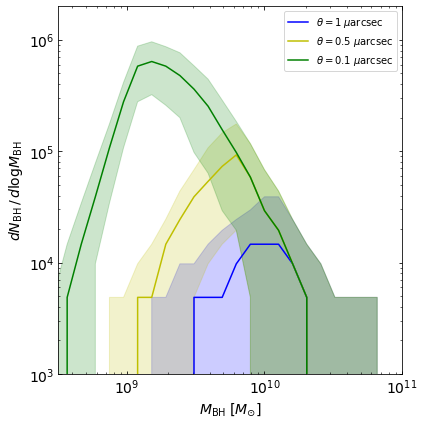

In [15]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
f_opt_cord=intlam03(cord_mass)*0+2*10**(-3)
# f_opt_lis=intminL(logM_lis)

# for i in tqdm(histarr):
#     ax.step(10**mass_bins[1:],i,color='b',alpha=.003)

# ax.loglog(10**logM_lis,nBH_over_LogM_known,c='g')


ax.loglog(10**cord_mass,dN_1_dlogM_med/f_opt_cord,c='b', label=r'$\theta=1\;\mu\rm{arcsec}$')
ax.fill_between(10**cord_mass,*[f_opt_cord**(-1),f_opt_cord**(-1)]*np.transpose(dN_1_dlogM_90CL),color='b', alpha=0.2)

ax.loglog(10**cord_mass,dN_p01_dlogM_med/f_opt_cord,c='y', label=r'$\theta=0.5\;\mu\rm{arcsec}$')
ax.fill_between(10**cord_mass,*[f_opt_cord**(-1),f_opt_cord**(-1)]*np.transpose(dN_p01_dlogM_90CL),color='y', alpha=0.2)


ax.loglog(10**cord_mass,dN_p1_dlogM_med/f_opt_cord,c='g', label=r'$\theta=0.1\;\mu\rm{arcsec}$')
ax.fill_between(10**cord_mass,*[f_opt_cord**(-1),f_opt_cord**(-1)]*np.transpose(dN_p1_dlogM_90CL),color='g', alpha=0.2)

# ax.loglog(10**cord_mass,dN_p05_dlogM_med/f_opt_cord,c='g')
# ax.fill_between(10**cord_mass,*[f_opt_cord**(-1),f_opt_cord**(-1)]*np.transpose(dN_p05_dlogM_90CL),color='g', alpha=0.2)



# ax.loglog(10**logM_lis,dnq_dlogM_med2/f_opt_lis,c='r')
# ax.fill_between(10**logM_lis,*[f_opt_lis**(-1),f_opt_lis**(-1)]*np.transpose(dnq_dlogM_90CL2),color='r', alpha=0.2)

plt.ylabel(r'${dN_{\rm BH}}\,/\,{d\log M_{\rm BH}}$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)

plt.xlim(10**(8.5),10**11)
plt.ylim(10**(3),10**(6.3))

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)



plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.legend(loc='upper right',fontsize=10) 
plt.savefig('./figs/dN_dlogM.pdf')

plt.show()

### Total as a function of theta

In [16]:
theta_log_bins=np.logspace(-2,2,30)
theta_tot_arr=np.array([[len(x[x>i])  for x in rand_theta] for i in tqdm(theta_log_bins)])
theta_tot_med=np.array([np.median(x) for x in theta_tot_arr])
theta_tot_mean=np.array([np.mean(x) for x in theta_tot_arr])
theta_tot_std=np.array([np.std(x) for x in theta_tot_arr])
theta_tot_90CL=np.array([az.hdi(x,.9) for x in theta_tot_arr])

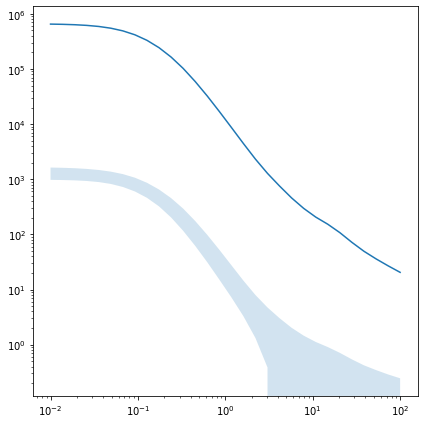

In [38]:
fig2, ax2 = plt.subplots(figsize=(6, 6), tight_layout=True)
# ax2.loglog(theta_log_bins,theta_tot_med)
ax2.loglog(theta_log_bins,theta_tot_mean/(2*10**(-3)))
# ax2.loglog(theta_log_bins,4*N_tot_theta)
# ax2.fill_between(theta_log_bins,*np.transpose(theta_tot_90CL),alpha=.2)
ax2.fill_between(theta_log_bins,theta_tot_mean+theta_tot_std,theta_tot_mean-theta_tot_std,alpha=.2)

plt.show()

### Distance function

In [18]:

dist_bins=np.logspace(0,np.log10(10*r_max),40)
# dDbins=dist_bins[1]-dist_bins[0]



hist_thetad_p1=np.array([np.histogram(rand_dist[i][dist_bool[i]][x>0.1],bins=dist_bins,density=True)[0]*len(rand_dist[i][dist_bool[i]][x>0.1]) for i,x in enumerate(tqdm(rand_theta, leave=True))])
hist_thetad_p5=np.array([np.histogram(rand_dist[i][dist_bool[i]][x>0.5],bins=dist_bins,density=True)[0]*len(rand_dist[i][dist_bool[i]][x>0.5]) for i,x in enumerate(tqdm(rand_theta, leave=True))])
hist_thetad_1=np.array([np.histogram(rand_dist[i][dist_bool[i]][x>1],bins=dist_bins,density=True)[0]*len(rand_dist[i][dist_bool[i]][x>1]) for i,x in enumerate(tqdm(rand_theta, leave=True))])
hist_thetad_10=np.array([np.histogram(rand_dist[i][dist_bool[i]][x>10],bins=dist_bins,density=True)[0]*len(rand_dist[i][dist_bool[i]][x>10]) for i,x in enumerate(tqdm(rand_theta, leave=True))])

cord_dist=np.sqrt(dist_bins[1:]*dist_bins[:-1])

/tomerv/nadavo/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [19]:
dN_1_dlogd_med=np.array([np.median(x) for x in (np.transpose(hist_thetad_1))])
dN_1_dlogd_90CL=np.array([az.hdi(x,0.9) for x in (np.transpose(hist_thetad_1))])
dN_1_dlogd_99CL=np.array([az.hdi(x,0.99) for x in (np.transpose(hist_thetad_1))])

dN_p1_dlogd_med=np.array([np.median(x) for x in (np.transpose(hist_thetad_p1))])
dN_p1_dlogd_90CL=np.array([az.hdi(x,0.9) for x in (np.transpose(hist_thetad_p1))])
dN_p1_dlogd_99CL=np.array([az.hdi(x,0.99) for x in (np.transpose(hist_thetad_p1))])

dN_10_dlogd_med=np.array([np.median(x) for x in (np.transpose(hist_thetad_10))])
dN_10_dlogd_90CL=np.array([az.hdi(x,0.9) for x in (np.transpose(hist_thetad_10))])
dN_10_dlogd_99CL=np.array([az.hdi(x,0.99) for x in (np.transpose(hist_thetad_10))])

dN_p5_dlogd_med=np.array([np.median(x) for x in (np.transpose(hist_thetad_p5))])
dN_p5_dlogd_90CL=np.array([az.hdi(x,0.9) for x in (np.transpose(hist_thetad_p5))])
dN_p5_dlogd_99CL=np.array([az.hdi(x,0.99) for x in (np.transpose(hist_thetad_p5))])

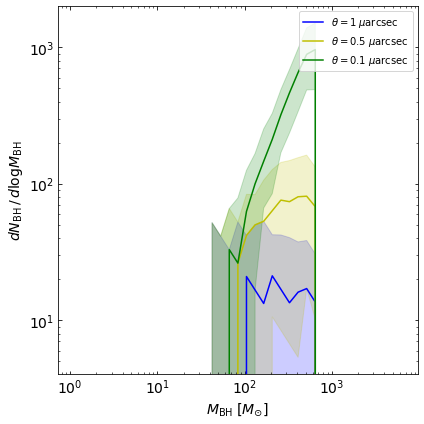

In [20]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
f_opt_cord=intlam03(cord_mass)*0+2*10**(-3)
# f_opt_lis=intminL(logM_lis)

# for i in tqdm(histarr):
#     ax.step(10**mass_bins[1:],i,color='b',alpha=.003)

# ax.loglog(10**logM_lis,nBH_over_LogM_known,c='g')


ax.loglog(cord_dist,dN_1_dlogd_med/f_opt_cord,c='b', label=r'$\theta=1\;\mu\rm{arcsec}$')
ax.fill_between(cord_dist,*[f_opt_cord**(-1),f_opt_cord**(-1)]*np.transpose(dN_1_dlogd_90CL),color='b', alpha=0.2)

ax.loglog(cord_dist,dN_p5_dlogd_med/f_opt_cord,c='y', label=r'$\theta=0.5\;\mu\rm{arcsec}$')
ax.fill_between(cord_dist,*[f_opt_cord**(-1),f_opt_cord**(-1)]*np.transpose(dN_p5_dlogd_90CL),color='y', alpha=0.2)


ax.loglog(cord_dist,dN_p1_dlogd_med/f_opt_cord,c='g', label=r'$\theta=0.1\;\mu\rm{arcsec}$')
ax.fill_between(cord_dist,*[f_opt_cord**(-1),f_opt_cord**(-1)]*np.transpose(dN_p1_dlogd_90CL),color='g', alpha=0.2)

# ax.loglog(10**cord_mass,dN_p05_dlogM_med/f_opt_cord,c='g')
# ax.fill_between(10**cord_mass,*[f_opt_cord**(-1),f_opt_cord**(-1)]*np.transpose(dN_p05_dlogM_90CL),color='g', alpha=0.2)



# ax.loglog(10**logM_lis,dnq_dlogM_med2/f_opt_lis,c='r')
# ax.fill_between(10**logM_lis,*[f_opt_lis**(-1),f_opt_lis**(-1)]*np.transpose(dnq_dlogM_90CL2),color='r', alpha=0.2)

plt.ylabel(r'${dN_{\rm BH}}\,/\,{d\log M_{\rm BH}}$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)

# plt.xlim(10**(8.5),10**11)
# plt.ylim(10**(3),10**(6.3))

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)



plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.legend(loc='upper right',fontsize=10) 
plt.savefig('./figs/dN_dlogD.pdf')

plt.show()

# Statistics - grav

### A smarter statistics

In [21]:

rand_grav=np.array([grav_BH(x,cmd_to_add(rand_dist[i][dist_bool[i]])*u.Mpc).value for i, x in enumerate(tqdm(rand_mass, leave=True))])

# hist_mass_grav=np.array([np.histogram(x,bins=mass_bins,density=True)[0]*len(x)/vol_max for i,x in enumerate(tqdm(rand_mass, leave=True))])
hist_grav_p1=np.array([np.histogram(x[rand_grav[i]>0.1],bins=mass_bins,density=True)[0]*len(x[rand_grav[i]>0.1]) for i,x in enumerate(tqdm(rand_mass, leave=True))])
# hist_grav_1=np.array([np.histogram(x[rand_grav[i]>1],bins=mass_bins,density=True)[0]*len(x[rand_grav[i]>1]) for i,x in enumerate(tqdm(rand_mass, leave=True))])
hist_grav_10=np.array([np.histogram(x[rand_grav[i]>.01],bins=mass_bins,density=True)[0]*len(x[rand_grav[i]>.01]) for i,x in enumerate(tqdm(rand_mass, leave=True))])

In [22]:
# dN_1_dlogM_med_grav=np.array([np.median(x) for x in (np.transpose(hist_grav_1))])
# dN_1_dlogM_90CL_grav=np.array([az.hdi(x,0.9) for x in (np.transpose(hist_grav_1))])
# dN_1_dlogM_99CL_grav=np.array([az.hdi(x,0.99) for x in (np.transpose(hist_grav_1))])

dN_10_dlogM_med_grav=np.array([np.median(x) for x in (np.transpose(hist_grav_10))])
dN_10_dlogM_90CL_grav=np.array([az.hdi(x,0.9) for x in (np.transpose(hist_grav_10))])
dN_10_dlogM_99CL_grav=np.array([az.hdi(x,0.99) for x in (np.transpose(hist_grav_10))])

dN_p1_dlogM_med_grav=np.array([np.median(x) for x in (np.transpose(hist_grav_p1))])
dN_p1_dlogM_90CL_grav=np.array([az.hdi(x,0.9) for x in (np.transpose(hist_grav_p1))])
dN_p1_dlogM_99CL_grav=np.array([az.hdi(x,0.99) for x in (np.transpose(hist_grav_p1))])


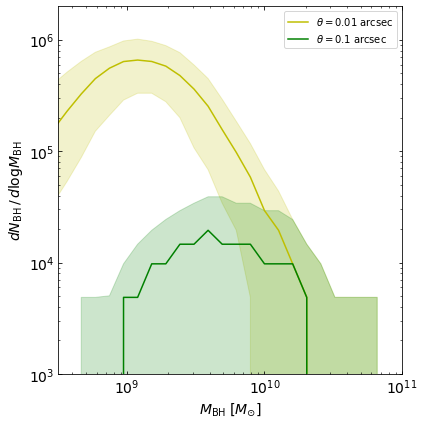

In [23]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
f_opt_cord=intlam03(cord_mass)*0+2*10**(-3)
# f_opt_lis=intminL(logM_lis)

# for i in tqdm(histarr):
#     ax.step(10**mass_bins[1:],i,color='b',alpha=.003)

# ax.loglog(10**logM_lis,nBH_over_LogM_known,c='g')


# ax.loglog(10**cord_mass,dN_1_dlogM_med_grav/f_opt_cord,c='b', label=r'$\theta=1\;\rm{arcsec}$')
# ax.fill_between(10**cord_mass,*[f_opt_cord**(-1),f_opt_cord**(-1)]*np.transpose(dN_1_dlogM_90CL_grav),color='b', alpha=0.2)

ax.loglog(10**cord_mass,dN_10_dlogM_med_grav/f_opt_cord,c='y', label=r'$\theta=0.01\;\rm{arcsec}$')
ax.fill_between(10**cord_mass,*[f_opt_cord**(-1),f_opt_cord**(-1)]*np.transpose(dN_10_dlogM_90CL_grav),color='y', alpha=0.2)


ax.loglog(10**cord_mass,dN_p1_dlogM_med_grav/f_opt_cord,c='g', label=r'$\theta=0.1\;\rm{arcsec}$')
ax.fill_between(10**cord_mass,*[f_opt_cord**(-1),f_opt_cord**(-1)]*np.transpose(dN_p1_dlogM_90CL_grav),color='g', alpha=0.2)

# ax.loglog(10**cord_mass,dN_p05_dlogM_med/f_opt_cord,c='g')
# ax.fill_between(10**cord_mass,*[f_opt_cord**(-1),f_opt_cord**(-1)]*np.transpose(dN_p05_dlogM_90CL),color='g', alpha=0.2)



# ax.loglog(10**logM_lis,dnq_dlogM_med2/f_opt_lis,c='r')
# ax.fill_between(10**logM_lis,*[f_opt_lis**(-1),f_opt_lis**(-1)]*np.transpose(dnq_dlogM_90CL2),color='r', alpha=0.2)

plt.ylabel(r'${dN_{\rm BH}}\,/\,{d\log M_{\rm BH}}$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)

plt.xlim(10**(8.5),10**11)
plt.ylim(10**(3),10**(6.3))

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)



plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.legend(loc='upper right',fontsize=10) 
plt.savefig('./figs/dNg_dlogM.pdf')

plt.show()

### Total as a function of theta

In [24]:
grav_log_bins=np.logspace(-3,1,30)
grav_tot_arr=np.array([[len(x[x>i])  for x in rand_grav] for i in tqdm(grav_log_bins)])
grav_tot_med=np.array([np.median(x) for x in grav_tot_arr])
grav_tot_mean=np.array([np.mean(x) for x in grav_tot_arr])
grav_tot_std=np.array([np.std(x) for x in grav_tot_arr])
grav_tot_90CL=np.array([az.hdi(x,.9) for x in grav_tot_arr])

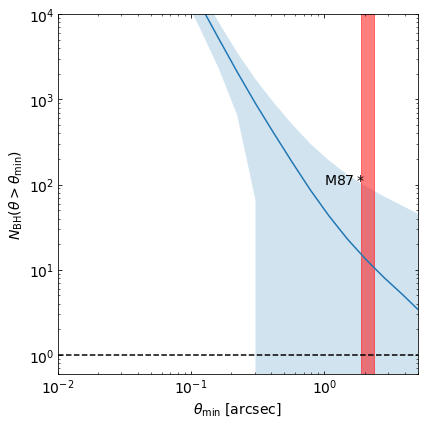

In [43]:


fig2, ax2 = plt.subplots(figsize=(6, 6), tight_layout=True)
# ax2.loglog(grav_log_bins,grav_tot_med)
# ax2.fill_between(grav_log_bins,*np.transpose(grav_tot_90CL),alpha=.2)


ax2.loglog(grav_log_bins,grav_tot_mean/(2*10**(-3)))
# ax2.loglog(theta_log_bins,4*N_tot_theta)

ax2.fill_between(grav_log_bins,(grav_tot_mean+grav_tot_std)/(2*10**(-3)),(grav_tot_mean-grav_tot_std)/(2*10**(-3)),alpha=.2)

ax2.axhline(y=1, ls='--',c='black')

ax2.axvspan(1.89736, 2.34255, alpha=0.5, color='red')

plt.ylim(.6,10**4)
plt.xlim(.01,5)

ax2.tick_params(axis='both', which='both', direction='in', top=True,right=True)



plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${N_{\rm BH}(\theta>\theta_{\rm min})}$', fontsize=14)
plt.xlabel(r'$\theta_{\rm min}\;[\rm arcsec]$', fontsize=14)



plt.text(1,100,r'$\rm{M}87*$', fontsize=14)

plt.savefig('./figs/N_theta.pdf')

plt.show()

plt.show()

# Local BH mass function

### Other fits
We are integrating up to $z_{\rm max}=z(r_{\rm max})$, and we only want to know the number of BH per steradian. This is given by
$$\frac{dN_{\rm BH}}{d \Omega}=\int_{z_{\rm max},>\theta}\Phi(M,z)\frac{dV_C(z)}{dz d\Omega}dz\,d\log M_{\rm BH}$$


In [26]:
logM_lis=np.linspace(8,12,300)
#from astro-ph/0405585, the Mass function is given by
nBH_over_LogM_known=0.106985*np.exp(- 0.230259*logM_lis-0.000149614*np.exp(1.12827*logM_lis))
dnBH_over_LogM_known=2.3*(np.exp(-0.00029922770964905924*np.exp(1.1282666955670824*logM_lis) - 0.9210340371976192*logM_lis)*
                      (9.350627489987536*10**(-10)*np.exp(1.588783714165892*logM_lis) + np.exp(2.7170504097329746*logM_lis)*
                       (6.587709473437998*10**(-12) + (-1.6000037292039514*10**(-12) + 1.0248314377431584*10**(-13)*logM_lis)*logM_lis) +
                       np.exp(0.4605170185988096*logM_lis)*(0.0002829030178177022 + (-0.00007147881917712672 +4.5783481430961345*10**(-6)*logM_lis)*logM_lis)))**0.5

In [27]:
# Fake angular diameter distance, defined as D_temp=GM/c^2𝜃, calculated usin 𝜃(M,DA=Mpc)/𝜃_0
D_temp_p01=theta_BH(logM_lis,u.Mpc)/(0.01*u.microarcsecond)
D_temp_p05=theta_BH(logM_lis,u.Mpc)/(0.05*u.microarcsecond)
D_temp_p1=theta_BH(logM_lis,u.Mpc)/(0.1*u.microarcsecond)

# Maximal z probed by our random observer
z_rmax=z_at_value(cosmo.comoving_distance,r_max*u.Mpc)

# Calculating the maximal z relevant for a mass bin: z<min[z_rmax,z(D_temp)]
def z_max_M(DA): 
    if DA<cosmo.angular_diameter_distance(z_rmax).value:
        return z_at_value(cosmo.angular_diameter_distance,DA*u.Mpc,zmax=z_rmax)
    else:
        return z_rmax
# List of redshifts.        
z_max_lis=np.linspace(10**(-10),z_rmax,400)

# Maximal z for 𝜃_0=0.1,0.01
z_max_p1=np.array([z_max_M(x) for x in D_temp_p1])
z_max_p01=np.array([z_max_M(x) for x in D_temp_p01])
z_max_p05=np.array([z_max_M(x) for x in D_temp_p05])

dN_p01_dlogM_known=nBH_over_LogM_known*cosmo.comoving_volume(z_max_p01).value/np.pi/4
dN_p05_dlogM_known=nBH_over_LogM_known*cosmo.comoving_volume(z_max_p05).value/np.pi/4
dN_p1_dlogM_known=nBH_over_LogM_known*cosmo.comoving_volume(z_max_p1).value/np.pi/4

ddN_p01_dlogM_known=dnBH_over_LogM_known*cosmo.comoving_volume(z_max_p01).value/np.pi/4
ddN_p05_dlogM_known=dnBH_over_LogM_known*cosmo.comoving_volume(z_max_p05).value/np.pi/4
ddN_p1_dlogM_known=dnBH_over_LogM_known*cosmo.comoving_volume(z_max_p1).value/np.pi/4

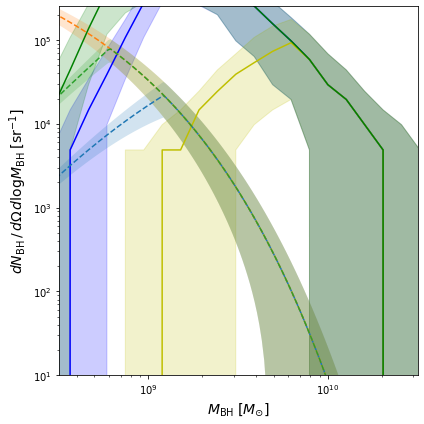

In [28]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)


ax.loglog(10**cord_mass,dN_p1_dlogM_med/f_opt_cord,c='b')
ax.fill_between(10**cord_mass,*[f_opt_cord**(-1),f_opt_cord**(-1)]*np.transpose(dN_p1_dlogM_90CL),color='b', alpha=0.2)

ax.loglog(10**cord_mass,dN_p01_dlogM_med/f_opt_cord,c='y')
ax.fill_between(10**cord_mass,*[f_opt_cord**(-1),f_opt_cord**(-1)]*np.transpose(dN_p01_dlogM_90CL),color='y', alpha=0.2)

ax.loglog(10**cord_mass,dN_p05_dlogM_med/f_opt_cord,c='g')
ax.fill_between(10**cord_mass,*[f_opt_cord**(-1),f_opt_cord**(-1)]*np.transpose(dN_p05_dlogM_90CL),color='g', alpha=0.2)

ax.loglog(10**logM_lis,dN_p1_dlogM_known,ls='--')
ax.fill_between(10**logM_lis,dN_p1_dlogM_known+ddN_p1_dlogM_known,dN_p1_dlogM_known-ddN_p1_dlogM_known,alpha=.2)

ax.loglog(10**logM_lis,dN_p01_dlogM_known,ls='--')
ax.fill_between(10**logM_lis,dN_p01_dlogM_known+ddN_p01_dlogM_known,dN_p01_dlogM_known-ddN_p01_dlogM_known,alpha=.2)

ax.loglog(10**logM_lis,dN_p05_dlogM_known,ls='--')
ax.fill_between(10**logM_lis,dN_p05_dlogM_known+ddN_p05_dlogM_known,dN_p05_dlogM_known-ddN_p05_dlogM_known,alpha=.2)

plt.ylabel(r'${dN_{\rm BH}}\,/\,{d\Omega\,d\log M_{\rm BH}}\;\left[\rm{sr^{-1}}\right]$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)

plt.xlim(10**(8.5),10**10.5)
plt.ylim(10**(1),10**(5.4))


# plt.savefig('n_vs_M.jpg')

plt.show()

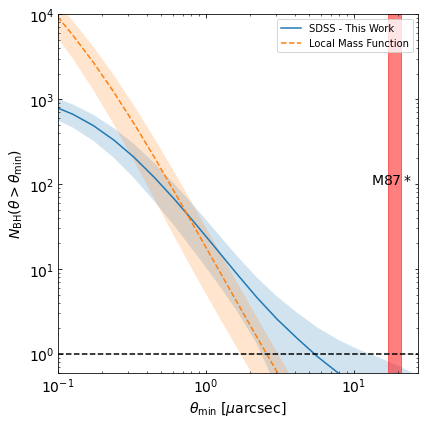

In [33]:
logM_min_z=np.array([np.log10(x*u.microarcsecond/theta_BH(0,cosmo.angular_diameter_distance(z_max_lis))) for x in theta_log_bins])
dVCdz=cosmo.differential_comoving_volume(z_max_lis).value;
dN_dOmega_known=np.array([np.trapz(4*np.pi*dVCdz*[np.trapz(nBH_over_LogM_known[logM_lis>x[i]],logM_lis[logM_lis>x[i]]) for i,z in enumerate(z_max_lis)],z_max_lis) for x in logM_min_z])
ddN_dOmega_known=np.array([np.trapz(4*np.pi*dVCdz*[np.trapz(dnBH_over_LogM_known[logM_lis>x[i]],logM_lis[logM_lis>x[i]]) for i,z in enumerate(z_max_lis)],z_max_lis) for x in logM_min_z])


fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
# ax.loglog(theta_log_bins,theta_tot_mean)
# ax.fill_between(theta_log_bins,*np.transpose(theta_tot_90CL),alpha=.2)

ax.loglog(theta_log_bins,theta_tot_mean,label='SDSS - This Work')
ax.fill_between(theta_log_bins,theta_tot_mean+theta_tot_std,theta_tot_mean-theta_tot_std,alpha=.2)

ax.loglog(theta_log_bins,dN_dOmega_known,ls='--',label='Local Mass Function')
ax.fill_between(theta_log_bins,dN_dOmega_known+ddN_dOmega_known,dN_dOmega_known-ddN_dOmega_known,alpha=.2)

ax.axhline(y=1, ls='--',c='black')

ax.axvspan(5*3.4, 5*4.2, alpha=0.5, color='red')

plt.ylim(.6,10**4)
plt.xlim(.1,27)

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)



plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${N_{\rm BH}(\theta>\theta_{\rm min})}$', fontsize=14)
plt.xlabel(r'$\theta_{\rm min}\;[\mu \rm arcsec]$', fontsize=14)

ax.legend(loc='upper right',fontsize=10) 

plt.text(13,100,r'$\rm{M}87*$', fontsize=14)

plt.savefig('./figs/N_theta.pdf')

plt.show()

In [27]:
# Fake angular diameter distance grav, defined as D_temp=GM/c^2𝜃, calculated usin 𝜃(M,DA=Mpc)/𝜃_0
D_temp_grav_p01=grav_BH(logM_lis,u.Mpc)/(0.01*u.microarcsecond)
D_temp_grav_p05=grav_BH(logM_lis,u.Mpc)/(0.05*u.microarcsecond)
D_temp_grav_p1=grav_BH(logM_lis,u.Mpc)/(0.1*u.microarcsecond)



# Maximal z for 𝜃_0=0.1,0.01
z_max_p1=np.array([z_max_M(x) for x in D_temp_p1])
z_max_p01=np.array([z_max_M(x) for x in D_temp_p01])
z_max_p05=np.array([z_max_M(x) for x in D_temp_p05])

dN_p01_dlogM_known=nBH_over_LogM_known*cosmo.comoving_volume(z_max_p01).value/np.pi/4
dN_p05_dlogM_known=nBH_over_LogM_known*cosmo.comoving_volume(z_max_p05).value/np.pi/4
dN_p1_dlogM_known=nBH_over_LogM_known*cosmo.comoving_volume(z_max_p1).value/np.pi/4

ddN_p01_dlogM_known=dnBH_over_LogM_known*cosmo.comoving_volume(z_max_p01).value/np.pi/4
ddN_p05_dlogM_known=dnBH_over_LogM_known*cosmo.comoving_volume(z_max_p05).value/np.pi/4
ddN_p1_dlogM_known=dnBH_over_LogM_known*cosmo.comoving_volume(z_max_p1).value/np.pi/4

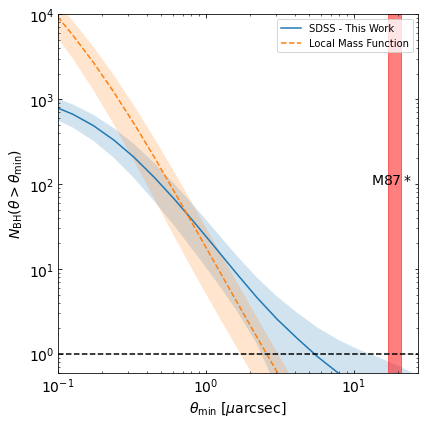

In [33]:
logM_min_z=np.array([np.log10(x*u.microarcsecond/theta_BH(0,cosmo.angular_diameter_distance(z_max_lis))) for x in theta_log_bins])
dVCdz=cosmo.differential_comoving_volume(z_max_lis).value;
dN_dOmega_known=np.array([np.trapz(4*np.pi*dVCdz*[np.trapz(nBH_over_LogM_known[logM_lis>x[i]],logM_lis[logM_lis>x[i]]) for i,z in enumerate(z_max_lis)],z_max_lis) for x in logM_min_z])
ddN_dOmega_known=np.array([np.trapz(4*np.pi*dVCdz*[np.trapz(dnBH_over_LogM_known[logM_lis>x[i]],logM_lis[logM_lis>x[i]]) for i,z in enumerate(z_max_lis)],z_max_lis) for x in logM_min_z])


fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
# ax.loglog(theta_log_bins,theta_tot_mean)
# ax.fill_between(theta_log_bins,*np.transpose(theta_tot_90CL),alpha=.2)

ax.loglog(theta_log_bins,theta_tot_mean,label='SDSS - This Work')
ax.fill_between(theta_log_bins,theta_tot_mean+theta_tot_std,theta_tot_mean-theta_tot_std,alpha=.2)

ax.loglog(theta_log_bins,dN_dOmega_known,ls='--',label='Local Mass Function')
ax.fill_between(theta_log_bins,dN_dOmega_known+ddN_dOmega_known,dN_dOmega_known-ddN_dOmega_known,alpha=.2)

ax.axhline(y=1, ls='--',c='black')

ax.axvspan(5*3.4, 5*4.2, alpha=0.5, color='red')

plt.ylim(.6,10**4)
plt.xlim(.1,27)

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)



plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${N_{\rm BH}(\theta>\theta_{\rm min})}$', fontsize=14)
plt.xlabel(r'$\theta_{\rm min}\;[\mu \rm arcsec]$', fontsize=14)

ax.legend(loc='upper right',fontsize=10) 

plt.text(13,100,r'$\rm{M}87*$', fontsize=14)

plt.savefig('./figs/N_theta.pdf')

plt.show()

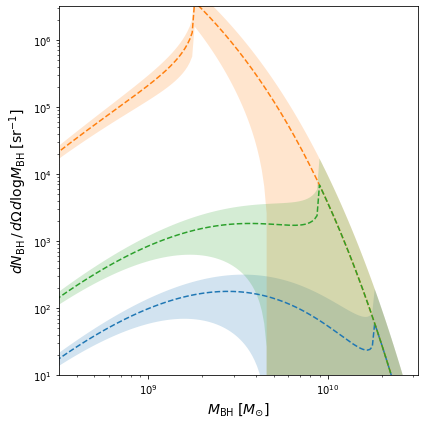

In [37]:
D_temp_p01=theta_BH(logM_lis,u.Mpc)/(0.01*u.microarcsecond)
D_temp_p05=theta_BH(logM_lis,u.Mpc)/(0.05*u.microarcsecond)
D_temp_p1=theta_BH(logM_lis,u.Mpc)/(0.1*u.microarcsecond)
# Maximal z probed by our random observer
z_rmax2=2

# Calculating the maximal z relevant for a mass bin: z<min[z_rmax,z(D_temp)]
def z_max_M2(DA): 
    if DA<cosmo.angular_diameter_distance(z_rmax2).value:
        return z_at_value(cosmo.angular_diameter_distance,DA*u.Mpc,zmax=z_rmax2)
    else:
        return z_rmax2
# List of redshifts.        
z_max_lis2=np.linspace(10**(-10),z_rmax2,400)

# Maximal z for 𝜃_0=0.1,0.01
z_max_p12=np.array([z_max_M2(x) for x in D_temp_p1])
z_max_p012=np.array([z_max_M2(x) for x in D_temp_p01])
z_max_p052=np.array([z_max_M2(x) for x in D_temp_p05])

dN_p01_dlogM_known2=nBH_over_LogM_known*cosmo.comoving_volume(z_max_p012).value/np.pi/4
dN_p05_dlogM_known2=nBH_over_LogM_known*cosmo.comoving_volume(z_max_p052).value/np.pi/4
dN_p1_dlogM_known2=nBH_over_LogM_known*cosmo.comoving_volume(z_max_p12).value/np.pi/4

ddN_p01_dlogM_known2=dnBH_over_LogM_known*cosmo.comoving_volume(z_max_p012).value/np.pi/4
ddN_p05_dlogM_known2=dnBH_over_LogM_known*cosmo.comoving_volume(z_max_p052).value/np.pi/4
ddN_p1_dlogM_known2=dnBH_over_LogM_known*cosmo.comoving_volume(z_max_p12).value/np.pi/4


fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)



ax.loglog(10**logM_lis,dN_p1_dlogM_known2,ls='--')
ax.fill_between(10**logM_lis,dN_p1_dlogM_known2+ddN_p1_dlogM_known2,dN_p1_dlogM_known2-ddN_p1_dlogM_known2,alpha=.2)

ax.loglog(10**logM_lis,dN_p01_dlogM_known2,ls='--')
ax.fill_between(10**logM_lis,dN_p01_dlogM_known2+ddN_p01_dlogM_known2,dN_p01_dlogM_known2-ddN_p01_dlogM_known2,alpha=.2)

ax.loglog(10**logM_lis,dN_p05_dlogM_known2,ls='--')
ax.fill_between(10**logM_lis,dN_p05_dlogM_known2+ddN_p05_dlogM_known2,dN_p05_dlogM_known2-ddN_p05_dlogM_known2,alpha=.2)

plt.ylabel(r'${dN_{\rm BH}}\,/\,{d\Omega\,d\log M_{\rm BH}}\;\left[\rm{sr^{-1}}\right]$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)

plt.xlim(10**(8.5),10**10.5)
plt.ylim(10**(1),10**(6.5))


# plt.savefig('n_vs_M.jpg')


plt.show()

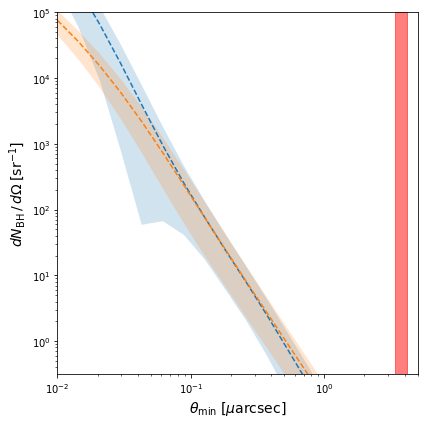

In [38]:
logM_min_z2=np.array([np.log10(x*u.microarcsecond/theta_BH(0,cosmo.angular_diameter_distance(z_max_lis2))) for x in theta_log_bins])
dVCdz2=cosmo.differential_comoving_volume(z_max_lis2).value;
dN_dOmega_known2=np.array([np.trapz(dVCdz2*[np.trapz(nBH_over_LogM_known[logM_lis>x[i]],logM_lis[logM_lis>x[i]]) for i,z in enumerate(z_max_lis2)],z_max_lis2) for x in logM_min_z2])
ddN_dOmega_known2=np.array([np.trapz(dVCdz2*[np.trapz(dnBH_over_LogM_known[logM_lis>x[i]],logM_lis[logM_lis>x[i]]) for i,z in enumerate(z_max_lis2)],z_max_lis2) for x in logM_min_z2])


fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
# ax.loglog(theta_log_bins,theta_tot_med)
# ax.fill_between(theta_log_bins,*np.transpose(theta_tot_90CL),alpha=.2)

ax.loglog(theta_log_bins,dN_dOmega_known2,ls='--')
ax.fill_between(theta_log_bins,dN_dOmega_known2+ddN_dOmega_known2,dN_dOmega_known2-ddN_dOmega_known2,alpha=.2)

ax.loglog(theta_log_bins,dN_dOmega_known,ls='--')
ax.fill_between(theta_log_bins,dN_dOmega_known+ddN_dOmega_known,dN_dOmega_known-ddN_dOmega_known,alpha=.2)

ax.axvspan(3.4, 4.2, alpha=0.5, color='red')

plt.ylim(10**(-.5),10**5)
plt.xlim(.01,5)

plt.ylabel(r'${dN_{\rm BH}}\,/\,d\Omega\;\left[\rm{sr^{-1}}\right]$', fontsize=14)
plt.xlabel(r'$\theta_{\rm min}\;[\mu \rm arcsec]$', fontsize=14)

plt.show()

## Trying a different approach
The mean number of BHs seen with angular size larger than $\theta$, can be shown to be
$$\sum_i\frac{V_i}{V_{\rm SDSS}}\;\;V_i=\frac{4\pi}{3}(\min\left[r_{\rm max},r_M\right])^3$$
where 
$$D_A(r_M)=\frac{5GM}{\theta c^2}$$

In [4]:
def theta_5BH(logM,DA):
    return (5*const.G*const.M_sun*u.rad*10**logM/DA/(const.c)**2).to(u.microarcsecond)

# Calculating the maximal z relevant for a mass bin: z<min[z_rmax,z(D_temp)]
def VC_DA_rmax(DA,rmax): 
    zm=z_at_value(cosmo.comoving_distance,rmax*u.Mpc)
    if DA<cosmo.angular_diameter_distance(zm).value:
        return cosmo.comoving_volume(z_at_value(cosmo.angular_diameter_distance,DA*u.Mpc,zmax=zm))
    else:
        return cosmo.comoving_volume(zm)
    
DAlis=theta_5BH(mass_new,u.Mpc)/u.microarcsecond
np.array([VC_DA_rmax(x,700) for x in DAlis])

TypeError: only dimensionless scalar quantities can be converted to Python scalars

## Functions

In [307]:
# Probability that theta_shad>theta
def F_shad(x,sig):
    xos=x/(np.sqrt(2)*sig)
    return x*erfc(xos)-np.sqrt(2/np.pi)*sig*np.exp(-xos**2)

def P_shad(Q,sig):
    Sig=np.sqrt(sig**2+(np.log10(3)/3)**2)
    return (1/(4*0.17))*(F_shad(Q+0.17,Sig)-F_shad(Q-0.17,Sig))

def Gauss(m,mb,sig):
    return 1/(sig * np.sqrt(2 * np.pi)) *np.exp( - (m - mb)**2 / (2 * sig**2) )

In [308]:
# Log of the BH shaddow array Nrandom*NQ
qshadarr=np.array([np.log10(msun_over_Mpc_to_muas)+mass_new-np.log10(x) for x in tqdm(lam_dist)]) 

We denote $p={\{\rm random\;points\}}\;\;q=\{\rm quasars\}$, and define the probability that the shaddow of a qusar $q$, seen by a point $p$ is larer than $\theta$ by $P_{p,q}(\theta)$. 
However, we need to get rid of $p,q$ pairs that are more than $r_\max$ apart. We do so by using the boolean array dist_bool

In [309]:
# Generating P_{p,q}/f({0.1,0,5})
theta_m1_shad_arr=np.array([P_shad(-1-x[dist_bool[i]],dmass_new[dist_bool[i]])/(lamlis[dist_bool[i]]) for i,x in enumerate(tqdm(qshadarr))])
theta_0_shad_arr=np.array([P_shad(0-x[dist_bool[i]],dmass_new[dist_bool[i]])/(lamlis[dist_bool[i]]) for i,x in enumerate(tqdm(qshadarr))])
theta_1_shad_arr=np.array([P_shad(1-x[dist_bool[i]],dmass_new[dist_bool[i]])/(lamlis[dist_bool[i]]) for i,x in enumerate(tqdm(qshadarr))])

## Predicted observed BH mass function as a function of resolution

Each quasar comes with a mass PDF $\rho_q(\log_{10} M_q)$. We therefore generate $|p|$ samples of the BH mass function (Einstein summation)
$$\frac{d N_p(\theta)}{d\log M}= P_{p,q}(\theta)\rho_q.$$
Here, too, we need to get rid of $p,q$ pairs that are more than $r_\max$ apart. We do so by using the boolean array dist_bool

In [310]:
bins=np.linspace(8,11.4,200)
rho_LogM_bins_vec=np.array([Gauss(x,mass_new,dmass_new) for x in bins])

In [311]:
theta_m1_shad_LogM=np.array([rho_LogM_bins_vec[:,dist_bool[i]]@x for i,x in enumerate(tqdm(theta_m1_shad_arr))])
theta_0_shad_LogM=np.array([rho_LogM_bins_vec[:,dist_bool[i]]@x for i,x in enumerate(tqdm(theta_0_shad_arr))])
theta_1_shad_LogM=np.array([rho_LogM_bins_vec[:,dist_bool[i]]@x for i,x in enumerate(tqdm(theta_1_shad_arr))])

In [312]:
theta_m1_shad_mean_LogM=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_m1_shad_LogM))])
theta_0_shad_mean_LogM=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_0_shad_LogM))])
theta_1_shad_mean_LogM=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_1_shad_LogM))])

theta_m1_shad_CL09_LogM=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_m1_shad_LogM))])
theta_0_shad_CL09_LogM=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_0_shad_LogM))])
theta_1_shad_CL09_LogM=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_1_shad_LogM))])

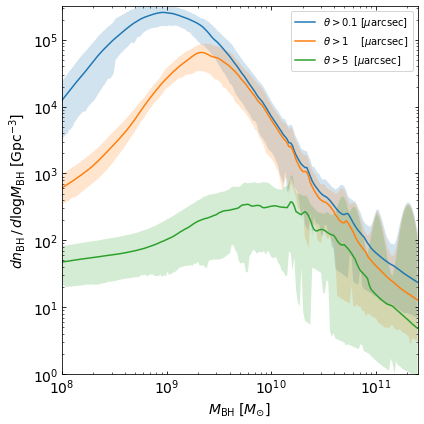

In [313]:
vol=4*np.pi*(r_max/1000)**3/3 
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**bins,theta_m1_shad_mean_LogM/vol,label=r'$\theta>0.1\;[\mu\rm{arcsec}]$')
ax.fill_between(10**bins,*np.transpose([vol**(-1),vol**(-1)]*theta_m1_shad_CL09_LogM), alpha=0.2)

ax.loglog(10**bins,theta_0_shad_mean_LogM/vol,label=r'$\theta>1\;\;\;\;\,[\mu\rm{arcsec}]$')
ax.fill_between(10**bins,*np.transpose([vol**(-1),vol**(-1)]*theta_0_shad_CL09_LogM), alpha=0.2)

ax.loglog(10**bins,theta_1_shad_mean_LogM/vol,label=r'$\theta>5\;\;[\mu\rm{arcsec}]$')
ax.fill_between(10**bins,*np.transpose([vol**(-1),vol**(-1)]*theta_1_shad_CL09_LogM), alpha=0.2)


# ax.loglog(10**bins,10**savgol_filter(np.log10(theta_m1_shad_CL09_LogM[:,0]),11,1)/vol,'.',label=r'$\theta>0.1\;[\mu\rm{arcsec}]$')

# ax.tick_params(which='both',right=True,top=True,direction='in')
ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log M_{\rm BH}}\;\left[\rm{Gpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)
plt.ylim(10**(-0),10**5.5)
plt.xlim(10**(8),10**bins[-1])

ax.legend(loc='upper right',fontsize=10) 

plt.show()

Smooth version

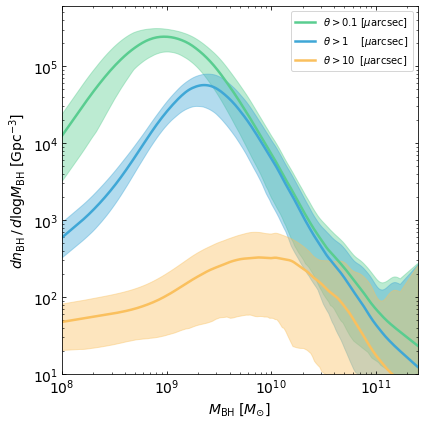

In [314]:
# colis=np.flip(sns.color_palette("Blues",n_colors=3),axis=0)
colis=np.flip(['#fac05e','#3fa7d6','#59cd90'])

smod_m1_shad_mean_LogM=10**savgol_filter(np.log10(theta_m1_shad_mean_LogM),21,1)/vol
smod_m1_shad_CL09_LogM=np.array([10**savgol_filter(np.log10(theta_m1_shad_CL09_LogM[:,i]),21,1)/vol for i in range(2)])

smod_1_shad_mean_LogM=10**savgol_filter(np.log10(theta_1_shad_mean_LogM),21,1)/vol
smod_1_shad_CL09_LogM=np.array([10**savgol_filter(np.log10(theta_1_shad_CL09_LogM[:,i]),21,1)/vol for i in range(2)])

smod_0_shad_mean_LogM=10**savgol_filter(np.log10(theta_0_shad_mean_LogM),21,1)/vol
smod_0_shad_CL09_LogM=np.array([10**savgol_filter(np.log10(theta_0_shad_CL09_LogM[:,i]),21,1)/vol for i in range(2)])

fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**bins,smod_m1_shad_mean_LogM,c=colis[0], linewidth=2.5,label=r'$\theta>0.1\;[\mu\rm{arcsec}]$')
ax.fill_between(10**bins,*smod_m1_shad_CL09_LogM,color=colis[0], alpha=0.4)


ax.loglog(10**bins,smod_0_shad_mean_LogM,c=colis[1],linewidth=2.5,label=r'$\theta>1\;\;\;\;\,[\mu\rm{arcsec}]$')
ax.fill_between(10**bins,*smod_0_shad_CL09_LogM,color=colis[1], alpha=0.4)

ax.loglog(10**bins,smod_1_shad_mean_LogM,c=colis[2],linewidth=2.5,label=r'$\theta>10\;\;[\mu\rm{arcsec}]$')
ax.fill_between(10**bins,*smod_1_shad_CL09_LogM,color=colis[2], alpha=0.4)


ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log M_{\rm BH}}\;\left[\rm{Gpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)
plt.ylim(10**(1),6*10**5)
plt.xlim(10**(8),10**bins[-1])

ax.legend(loc='upper right',fontsize=10) 

plt.savefig('mass_shad.pdf')

plt.show()



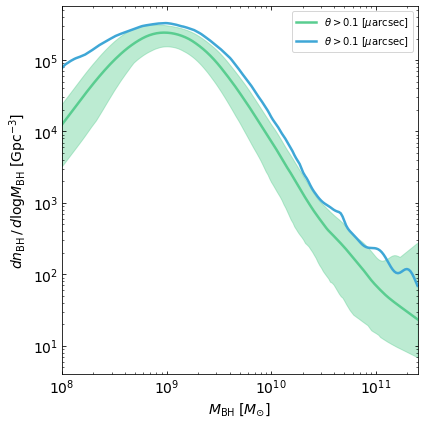

In [315]:

this=np.array([np.minimum(1,x) for x in (((2.02622*10**10)**(-1))*(10**bins))**3])
this2=np.array([np.minimum(1,x) for x in (((2.02622*9**10)**(-1))*(10**bins))**3])

fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**bins,smod_m1_shad_mean_LogM,c=colis[0], linewidth=2.5,label=r'$\theta>0.1\;[\mu\rm{arcsec}]$')
ax.fill_between(10**bins,*smod_m1_shad_CL09_LogM,color=colis[0], alpha=0.4)


ax.loglog(10**bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)) for x in bins])/(intminL(bins)*Vol(z_min,z_max).to(u.Gpc**3).value) ,c=colis[1], linewidth=2.5,label=r'$\theta>0.1\;[\mu\rm{arcsec}]$')
# ax.loglog(10**bins,this*smod_m1_shad_mean_LogM,c=colis[0], linewidth=2.5,label=r'$\theta>0.1\;[\mu\rm{arcsec}]$')
# ax.fill_between(10**bins,*[this,this]*smod_m1_shad_CL09_LogM,color=colis[0], alpha=0.4)
# ax.loglog(10**bins,this2*smod_m1_shad_mean_LogM,c=colis[0], linewidth=2.5,label=r'$\theta>0.1\;[\mu\rm{arcsec}]$')
# ax.fill_between(10**bins,*[this2,this2]*smod_m1_shad_CL09_LogM,color=colis[0], alpha=0.4)


# ax.loglog(10**bins,smod_0_shad_mean_LogM,c=colis[1],linewidth=2.5,label=r'$\theta>1\;\;\;\;\,[\mu\rm{arcsec}]$')
# ax.fill_between(10**bins,*smod_0_shad_CL09_LogM,color=colis[1], alpha=0.4)

# ax.loglog(10**bins,smod_1_shad_mean_LogM,c=colis[2],linewidth=2.5,label=r'$\theta>10\;\;[\mu\rm{arcsec}]$')
# ax.fill_between(10**bins,*smod_1_shad_CL09_LogM,color=colis[2], alpha=0.4)


ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log M_{\rm BH}}\;\left[\rm{Gpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)
# plt.ylim(10**(1),6*10**5)
plt.xlim(10**(8),10**bins[-1])

ax.legend(loc='upper right',fontsize=10) 

plt.savefig('mass_shad.pdf')

plt.show()



## Predicted observed BH distances function as a function of resolution

Each quasar comes with a distance PDF $\rho_D(\log_{10} D_q)$. We therefore generate $|p|$ samples of the BH distances function (Einstein summation)
$$\frac{d N_p(\theta)}{d\log M}= P_{p,q}(\theta)\rho_q.$$
Here, too, we need to get rid of $p,q$ pairs that are more than $r_\max$ apart. We do so by using the boolean array dist_bool

In [175]:
short_dist=np.array([x[dist_bool[i]] for i,x in enumerate(tqdm(lam_dist))])

In [176]:
bins_D=np.linspace(-3,np.log10(r_max),50)
rho_LogD_bins_arr=np.array([[Gauss(x,np.log10(y),np.log10(3))  for y in tqdm(short_dist,leave=False)] for x in tqdm(bins_D)])

In [177]:
theta_m1_shad_LogD=np.array([np.stack(rho_LogD_bins_arr[:,i])@x for i,x in enumerate(tqdm(theta_m1_shad_arr))])
theta_0_shad_LogD=np.array([np.stack(rho_LogD_bins_arr[:,i])@x for i,x in enumerate(tqdm(theta_0_shad_arr))])
theta_1_shad_LogD=np.array([np.stack(rho_LogD_bins_arr[:,i])@x for i,x in enumerate(tqdm(theta_1_shad_arr))])

In [178]:
theta_m1_shad_mean_LogD=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_m1_shad_LogD))])
theta_0_shad_mean_LogD=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_0_shad_LogD))])
theta_1_shad_mean_LogD=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_1_shad_LogD))])

theta_m1_shad_CL09_LogD=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_m1_shad_LogD))])
theta_0_shad_CL09_LogD=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_0_shad_LogD))])
theta_1_shad_CL09_LogD=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_1_shad_LogD))])

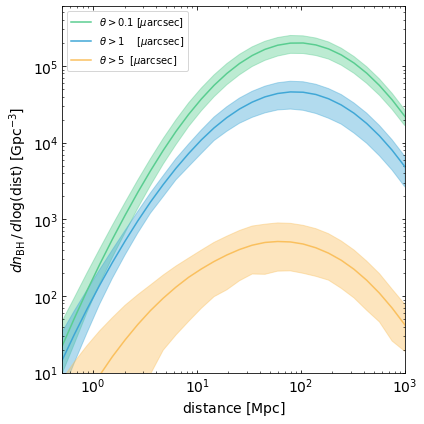

In [179]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**bins_D,theta_m1_shad_mean_LogD/vol,color=colis[0],label=r'$\theta>0.1\;[\mu\rm{arcsec}]$')
ax.fill_between(10**bins_D,*np.transpose([vol**(-1),vol**(-1)]*theta_m1_shad_CL09_LogD),color=colis[0], alpha=0.4)

ax.loglog(10**bins_D,theta_0_shad_mean_LogD/vol,color=colis[1],label=r'$\theta>1\;\;\;\;\,[\mu\rm{arcsec}]$')
ax.fill_between(10**bins_D,*np.transpose([vol**(-1),vol**(-1)]*theta_0_shad_CL09_LogD),color=colis[1], alpha=0.4)

ax.loglog(10**bins_D,theta_1_shad_mean_LogD/vol,color=colis[2],label=r'$\theta>5\;\;[\mu\rm{arcsec}]$')
ax.fill_between(10**bins_D,*np.transpose([vol**(-1),vol**(-1)]*theta_1_shad_CL09_LogD),color=colis[2], alpha=0.4)


# ax.tick_params(which='both',right=True,top=True,direction='in')
ax.tick_params(axis='both', which='both', direction='in', top=False,right=True)

ax.legend(loc='upper left',fontsize=10) 


# xval=10**np.linspace(-4,1,100)
# ttab=cosmo.comoving_distance(xval).value
# # forward=int1d(ttab,xval)
# # inverse=int1d(xval,ttab)
# def forward(x):
#     return np.interp(x,ttab,xval)


# def inverse(x):
#     return np.interp(x,xval,ttab)

# new_tick_locations=cosmo.comoving_distance(10**np.linspace(-1,0,2)).value
# secax = ax.secondary_xaxis('top', functions=(forward, inverse))
# secax.tick_params(axis='both', which='both', direction='in', top=True,right=True)
# secax.set_xlabel(r'$z$',fontsize=14)

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log ({\rm dist})}\;\left[\rm{Gpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'${\rm distance}\;\left[{\rm Mpc}\right]$', fontsize=14)
plt.ylim(10**(1),2*10**5)
plt.xlim(5*10**(-1),r_max)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log ({\rm dist})}\;\left[\rm{Gpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'${\rm distance}\;\left[{\rm Mpc}\right]$', fontsize=14)
plt.ylim(10**(1),6*10**5)
plt.xlim(5*10**(-1),r_max)

plt.savefig('dist_shad.pdf')

plt.show()

### $N_{BH}\; \rm{vs.}\; \theta$

In [180]:
median_ary=[]
CL_ary=[]
theta_range=np.linspace(-2,1.7,20)

for j in tqdm(theta_range):
    N_BH_temp=np.array([np.sum(P_shad(j-qshadarr[i][dist_bool[i]],(dmass_new)[dist_bool[i]])/lamlis[dist_bool[i]]) for i in trange(rand_N, leave=False)])
    median_ary.append(np.median(N_BH_temp))
    CL_ary.append(az.hdi(N_BH_temp, 0.9))
   

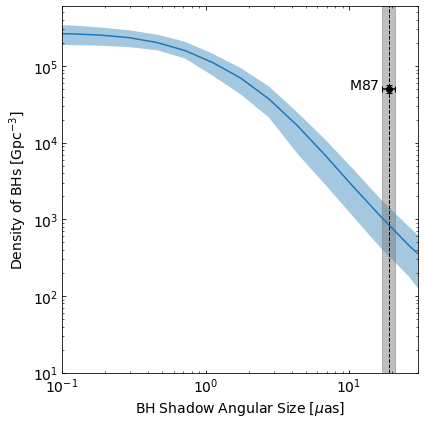

In [185]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)


ax.loglog(2*10**theta_range,np.array(median_ary)/vol)
ax.fill_between(2*10**theta_range,*np.transpose([vol**(-1),vol**(-1)]*(np.array(CL_ary)+10**(-5))), alpha=0.4)

ax.loglog(10**theta_range,theta_range*0+1,'--',color='black')

ax.axvline(x=19,c='black',ls='--',lw=1)
ax.axvspan(17, 21, alpha=0.5, color='gray')
# ax.axhline(y=50000,c='black',ls='--')
# ax.axhspan(45000, 57000, alpha=0.5, color='gray')

ax.errorbar(19,50000,6000,2,color='black',marker='o',capsize=3)

plt.text(10,50000,r'$\rm{M}87$', fontsize=14)

plt.ylim(10**(1),6*10**5)
plt.xlim(10**(-1),30)


ax.tick_params(which='both',right=True,top=True,direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${\rm Density\;of\;BHs\;\left[\rm{Gpc}^{-3}\right]}$', fontsize=14)
plt.xlabel(r'${\rm BH\;Shadow\;Angular\;Size}\;\left[\mu{\rm as}\right]$', fontsize=14)

plt.savefig('tot_shad.pdf')

plt.show()

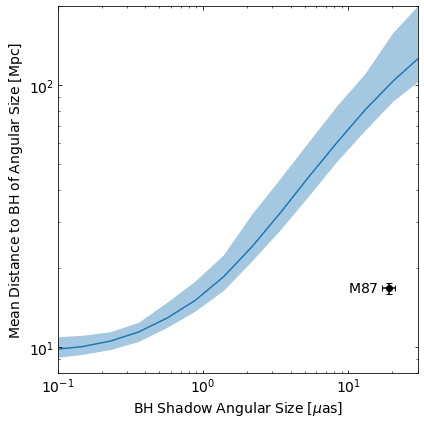

In [182]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)


ax.loglog(10**theta_range,r_max*np.array(median_ary)**(-1/3))
ax.fill_between(10**theta_range,*np.transpose([r_max,r_max]*((np.array(CL_ary)+10**(-10)))**(-1/3)), alpha=0.4)


# ax.axvline(x=19,c='black',ls='--',lw=1)
# ax.axvspan(17, 21, alpha=0.5, color='gray')
# ax.axhline(y=50000,c='black',ls='--')
# ax.axhspan(45000, 57000, alpha=0.5, color='gray')

ax.errorbar(19,16.8,.8,2,color='black',marker='o',capsize=3)

plt.text(10,16.2,r'$\rm{M}87$', fontsize=14)

plt.ylim(8,2*10**(2))
plt.xlim(10**(-1),30)


ax.tick_params(which='both',right=True,top=True,direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${\rm Mean\;Distance\;to\;BH\;of\;Angular\;Size\;\left[\rm{Mpc}\right]}$', fontsize=14)
plt.xlabel(r'${\rm BH\;Shadow\;Angular\;Size}\;\left[\mu{\rm as}\right]$', fontsize=14)

plt.savefig('dis_shad.pdf')

plt.show()

# Statistics - Gravity

## Functions

In [30]:
# Probability that theta_grav>theta

def P_grav(Q,m,sig):
    Sig=np.sqrt(0.2965*sig**2+0.0049*m**2+0.0878)
    return erfc(Q/np.sqrt(2)/Sig)/2

# a function that returns \theta_grav in arcsec using the M-sig relation.
def qgrav(log10M,dist_Mpc):
    return 0.54*log10M-np.log10(dist_Mpc)-3.48

In [31]:
# Log of the BH grav array Nrandom*NQ
qgravarr=np.array([qgrav(mass_new,x) for x in tqdm(lam_dist)]) 

We denote $p={\{\rm random\;points\}}\;\;q=\{\rm quasars\}$, and define the probability that the shaddow of a qusar $q$, seen by a point $p$ is larer than $\theta$ by $P_{p,q}(\theta)$. 
However, we need to get rid of $p,q$ pairs that are more than $r_\max$ apart. We do so by using the boolean array dist_bool

In [32]:
# Generating P_{p,q}({0.1,0,5})
theta_m1_grav_arr=np.array([P_grav(-1-x[dist_bool[i]],mass_new[dist_bool[i]],dmass_new[dist_bool[i]])/lamlis[dist_bool[i]] for i,x in enumerate(tqdm(qgravarr))])
theta_0_grav_arr=np.array([P_grav(0-x[dist_bool[i]],mass_new[dist_bool[i]],dmass_new[dist_bool[i]])/lamlis[dist_bool[i]] for i,x in enumerate(tqdm(qgravarr))])
theta_1_grav_arr=np.array([P_grav(1-x[dist_bool[i]],mass_new[dist_bool[i]],dmass_new[dist_bool[i]])/lamlis[dist_bool[i]] for i,x in enumerate(tqdm(qgravarr))])




## Predicted observed BH mass function as a function of resolution

Each quasar comes with a mass PDF $\rho_q(\log_{10} M_q)$. We therefore generate $|p|$ samples of the BH mass function (Einstein summation)
$$\frac{d N_p(\theta)}{d\log M}= P_{p,q}(\theta)\rho_q.$$
Here, too, we need to get rid of $p,q$ pairs that are more than $r_\max$ apart. We do so by using the boolean array dist_bool

In [33]:
theta_m1_grav_LogM=np.array([rho_LogM_bins_vec[:,dist_bool[i]]@x for i,x in enumerate(tqdm(theta_m1_grav_arr))])
theta_0_grav_LogM=np.array([rho_LogM_bins_vec[:,dist_bool[i]]@x for i,x in enumerate(tqdm(theta_0_grav_arr))])
theta_1_grav_LogM=np.array([rho_LogM_bins_vec[:,dist_bool[i]]@x for i,x in enumerate(tqdm(theta_1_grav_arr))])

In [34]:
theta_m1_grav_mean_LogM=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_m1_grav_LogM))])
theta_0_grav_mean_LogM=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_0_grav_LogM))])
theta_1_grav_mean_LogM=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_1_grav_LogM))])

theta_m1_grav_CL09_LogM=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_m1_grav_LogM))])
theta_0_grav_CL09_LogM=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_0_grav_LogM))])
theta_1_grav_CL09_LogM=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_1_grav_LogM))])

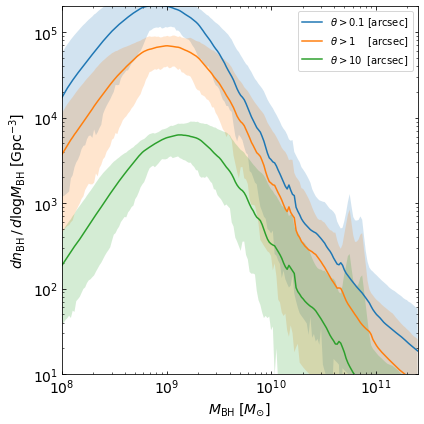

In [35]:

fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**bins,theta_m1_grav_mean_LogM/vol,label=r'$\theta>0.1\;[\rm{arcsec}]$')
ax.fill_between(10**bins,*np.transpose([vol**(-1),vol**(-1)]*theta_m1_grav_CL09_LogM), alpha=0.2)

ax.loglog(10**bins,theta_0_grav_mean_LogM/vol,label=r'$\theta>1\;\;\;\;\,[\rm{arcsec}]$')
ax.fill_between(10**bins,*np.transpose([vol**(-1),vol**(-1)]*theta_0_grav_CL09_LogM), alpha=0.2)

ax.loglog(10**bins,theta_1_grav_mean_LogM/vol,label=r'$\theta>10\;\;[\rm{arcsec}]$')
ax.fill_between(10**bins,*np.transpose([vol**(-1),vol**(-1)]*theta_1_grav_CL09_LogM), alpha=0.2)


# ax.tick_params(which='both',right=True,top=True,direction='in')
ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log M_{\rm BH}}\;\left[\rm{Gpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)
plt.ylim(10**(1),2*10**5)
plt.xlim(10**(8),10**bins[-1])

ax.legend(loc='upper right',fontsize=10) 

plt.show()

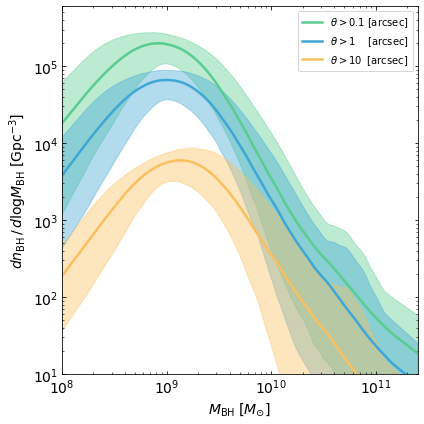

In [36]:
smod_m1_grav_mean_LogM=10**savgol_filter(np.log10(theta_m1_grav_mean_LogM),21,1)/vol
smod_m1_grav_CL09_LogM=np.array([10**savgol_filter(np.log10(theta_m1_grav_CL09_LogM[:,i]),21,1)/vol for i in range(2)])

smod_1_grav_mean_LogM=10**savgol_filter(np.log10(theta_1_grav_mean_LogM),21,1)/vol
smod_1_grav_CL09_LogM=np.array([10**savgol_filter(np.log10(theta_1_grav_CL09_LogM[:,i]),21,1)/vol for i in range(2)])

smod_0_grav_mean_LogM=10**savgol_filter(np.log10(theta_0_grav_mean_LogM),21,1)/vol
smod_0_grav_CL09_LogM=np.array([10**savgol_filter(np.log10(theta_0_grav_CL09_LogM[:,i]),21,1)/vol for i in range(2)])

fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**bins,smod_m1_grav_mean_LogM,c=colis[0], linewidth=2.5,label=r'$\theta>0.1\;[\rm{arcsec}]$')
ax.fill_between(10**bins,*smod_m1_grav_CL09_LogM,color=colis[0], alpha=0.4)


ax.loglog(10**bins,smod_0_grav_mean_LogM,c=colis[1],linewidth=2.5,label=r'$\theta>1\;\;\;\;\,[\rm{arcsec}]$')
ax.fill_between(10**bins,*smod_0_grav_CL09_LogM,color=colis[1], alpha=0.4)
5
ax.loglog(10**bins,smod_1_grav_mean_LogM,c=colis[2],linewidth=2.5,label=r'$\theta>10\;\;[\rm{arcsec}]$')
ax.fill_between(10**bins,*smod_1_grav_CL09_LogM,color=colis[2], alpha=0.4)


ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log M_{\rm BH}}\;\left[\rm{Gpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'$M_{\rm BH}\;\left[M_{\odot}\right]$', fontsize=14)
plt.ylim(10**(1),6*10**5)
plt.xlim(10**(8),10**bins[-1])

ax.legend(loc='upper right',fontsize=10) 

plt.savefig('mass_grav.pdf')

plt.show()

## Predicted observed BH distances function as a function of resolution

Each quasar comes with a distance PDF $\rho_D(\log_{10} D_q)$. We therefore generate $|p|$ samples of the BH distances function (Einstein summation)
$$\frac{d N_p(\theta)}{d\log M}= P_{p,q}(\theta)\rho_q.$$
Here, too, we need to get rid of $p,q$ pairs that are more than $r_\max$ apart. We do so by using the boolean array dist_bool

In [37]:
theta_m1_grav_LogD=np.array([np.stack(rho_LogD_bins_arr[:,i])@x for i,x in enumerate(tqdm(theta_m1_grav_arr))])
theta_0_grav_LogD=np.array([np.stack(rho_LogD_bins_arr[:,i])@x for i,x in enumerate(tqdm(theta_0_grav_arr))])
theta_1_grav_LogD=np.array([np.stack(rho_LogD_bins_arr[:,i])@x for i,x in enumerate(tqdm(theta_1_grav_arr))])

In [38]:
theta_m1_grav_mean_LogD=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_m1_grav_LogD))])
theta_0_grav_mean_LogD=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_0_grav_LogD))])
theta_1_grav_mean_LogD=np.array([np.median(x) for i,x in enumerate(np.transpose(theta_1_grav_LogD))])

theta_m1_grav_CL09_LogD=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_m1_grav_LogD))])
theta_0_grav_CL09_LogD=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_0_grav_LogD))])
theta_1_grav_CL09_LogD=np.array([az.hdi(x,0.9) for i,x in enumerate(np.transpose(theta_1_grav_LogD))])

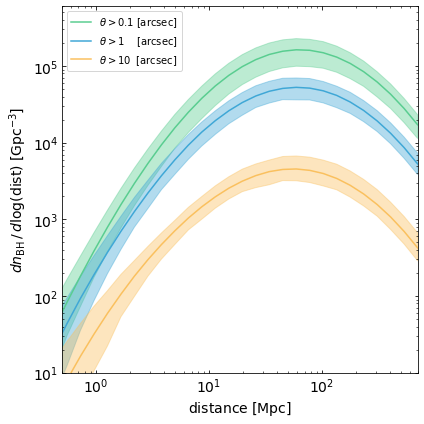

In [39]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**bins_D,theta_m1_grav_mean_LogD/vol,color=colis[0],label=r'$\theta>0.1\;[\rm{arcsec}]$')
ax.fill_between(10**bins_D,*np.transpose([vol**(-1),vol**(-1)]*theta_m1_grav_CL09_LogD),color=colis[0], alpha=0.4)

ax.loglog(10**bins_D,theta_0_grav_mean_LogD/vol,color=colis[1],label=r'$\theta>1\;\;\;\;\,[\rm{arcsec}]$')
ax.fill_between(10**bins_D,*np.transpose([vol**(-1),vol**(-1)]*theta_0_grav_CL09_LogD),color=colis[1], alpha=0.4)

ax.loglog(10**bins_D,theta_1_grav_mean_LogD/vol,color=colis[2],label=r'$\theta>10\;\;[\rm{arcsec}]$')
ax.fill_between(10**bins_D,*np.transpose([vol**(-1),vol**(-1)]*theta_1_grav_CL09_LogD),color=colis[2], alpha=0.4)


# ax.tick_params(which='both',right=True,top=True,direction='in')
ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${dn_{\rm BH}}\,/\,{d\log ({\rm dist})}\;\left[\rm{Gpc^{-3}}\right]$', fontsize=14)
plt.xlabel(r'${\rm distance}\;\left[{\rm Mpc}\right]$', fontsize=14)
plt.ylim(10**(1),6*10**5)
plt.xlim(5*10**(-1),r_max)

ax.legend(loc='upper left',fontsize=10) 

plt.savefig('dist_grav.pdf')

plt.show()

### $N_{BH}\; \rm{vs.}\; \theta$

In [40]:
median_grav_ary=[]
CL_grav_ary=[]
theta_range=np.linspace(-2,3,20)

for j in tqdm(theta_range):
    N_BH_temp=np.array([np.sum(P_grav(j-qgravarr[i][dist_bool[i]],mass_new[dist_bool[i]],(dmass_new)[dist_bool[i]])/lamlis[dist_bool[i]]) for i in trange(rand_N, leave=False)])
    median_grav_ary.append(np.median(N_BH_temp))
    CL_grav_ary.append(az.hdi(N_BH_temp, 0.9))
   

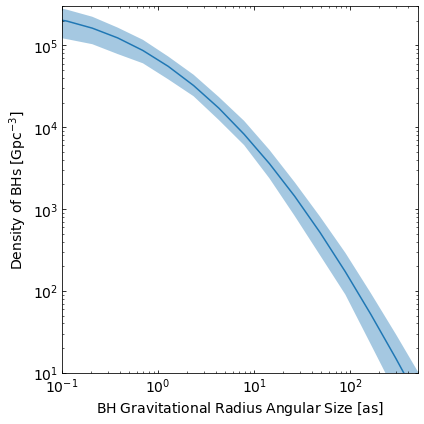

In [41]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)


ax.loglog(10**theta_range,np.array(median_grav_ary)/vol)
ax.fill_between(10**theta_range,*np.transpose([vol**(-1),vol**(-1)]*(np.array(CL_grav_ary)+10**(-5))), alpha=0.4)

ax.loglog(10**theta_range,theta_range*0+1,'--',color='black')

plt.ylim(10**(1),3*10**5)
plt.xlim(10**(-1),500)


ax.tick_params(which='both',right=True,top=True,direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${\rm Density\;of\;BHs\;\left[\rm{Gpc}^{-3}\right]}$', fontsize=14)
plt.xlabel(r'${\rm BH\;Gravitational\;Radius\;Angular\;Size}\;\left[{\rm as}\right]$', fontsize=14)

plt.savefig('tot_grav.pdf')

plt.show()

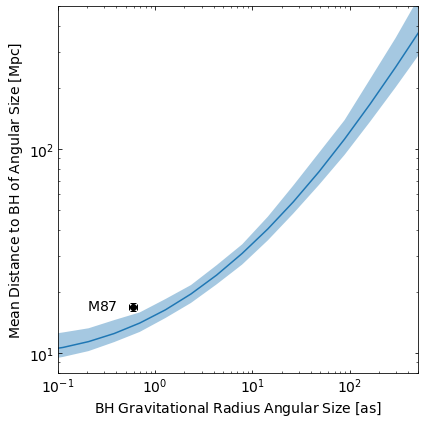

In [57]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)


ax.loglog(10**theta_range,r_max*np.array(median_grav_ary)**(-1/3))
ax.fill_between(10**theta_range,*np.transpose([r_max,r_max]*((np.array(CL_grav_ary)+10**(-10)))**(-1/3)), alpha=0.4)


# ax.axvline(x=19,c='black',ls='--',lw=1)
# ax.axvspan(17, 21, alpha=0.5, color='gray')
# ax.axhline(y=50000,c='black',ls='--')
# ax.axhspan(45000, 57000, alpha=0.5, color='gray')

ax.errorbar(qgrav(np.log10(6.5*10**9),16.8),16.8,.8,.1*qgrav(np.log10(6.5*10**9),16.8),color='black',marker='o',capsize=3)

plt.text(0.2,16.2,r'$\rm{M}87$', fontsize=14)

plt.ylim(8,5*10**(2))
plt.xlim(10**(-1),500)


ax.tick_params(which='both',right=True,top=True,direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'${\rm Mean\;Distance\;to\;BH\;of\;Angular\;Size\;\left[\rm{Mpc}\right]}$', fontsize=14)
plt.xlabel(r'${\rm BH\;Gravitational\;Radius\;Angular\;Size}\;\left[{\rm as}\right]$', fontsize=14)

plt.savefig('dis_grav.pdf')

plt.show()

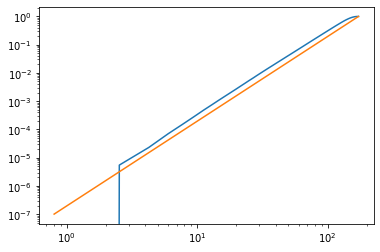

In [347]:
limdis=lam_dist[dist_bool]
disbin=np.linspace(np.min(limdis),np.max(limdis),100)
cdfdis=np.array([len(limdis[limdis<i]) for i in disbin])
plt.loglog(disbin,cdfdis/len(limdis))
plt.loglog(disbin,(disbin/np.max(limdis))**3)
plt.show()

In [317]:
scat=np.transpose(np.vstack((lam_dist[dist_bool],np.tile(mass_new,(rand_N,1))[dist_bool],qshadarr[dist_bool],qgravarr[dist_bool])))

Removed no burn in


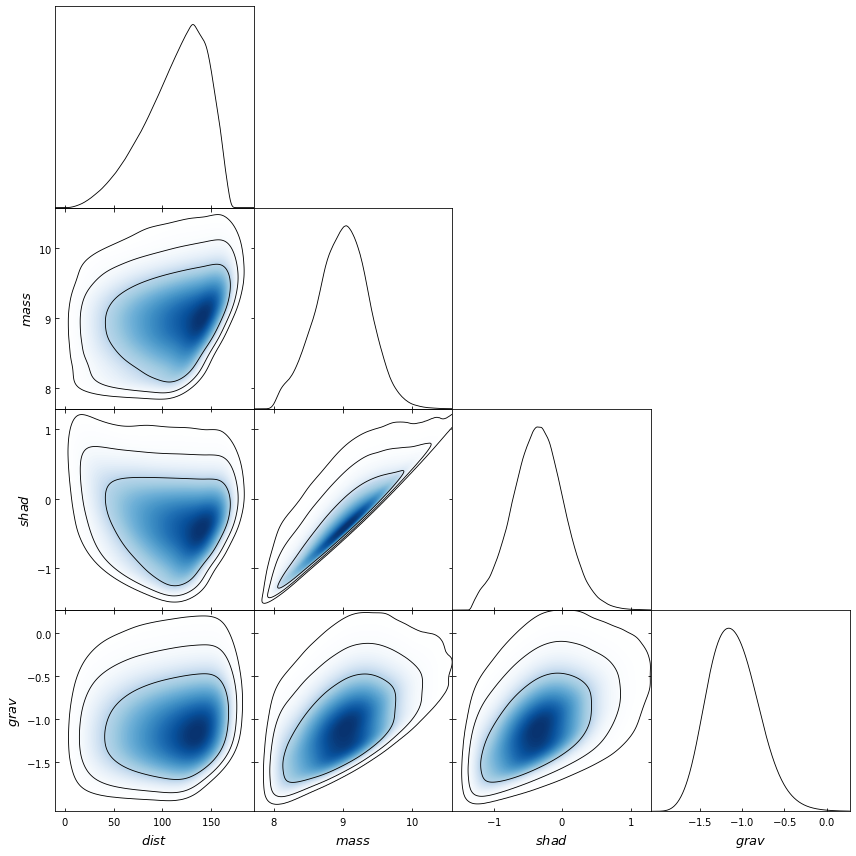

In [318]:
names2 = ["x%s"%i for i in range(4)]
labels2 =  ['dist','mass','shad','grav']



samples2 = MCSamples(samples=scat,names = names2, labels = labels2,settings={'smooth_scale_2D':0.3,'contours': [0.90, 0.99,.999]})


# g = plots.get_single_plotter(width_inch=4, ratio=1)
# g.plot_2d(samples, 'x0', 'x1', filled=True)
# g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# Triangle plot
g = plots.get_subplot_plotter(subplot_size=3)
g.settings.num_plot_contours = 3
g.triangle_plot(samples2,  shaded=True)
g.add_x_bands(1.3,.1)

plt.savefig('shadow_tri.pdf')

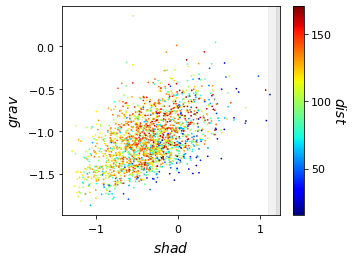

In [319]:
plots.set_active_style();

g = plots.get_single_plotter(width_inch=5)
g.plot_3d(samples2, ['x2', 'x3', 'x0'],settings={'smooth_scale_2D':0.3,'contours': [0.90, 0.99]})
g.add_x_bands(1.3,.1)

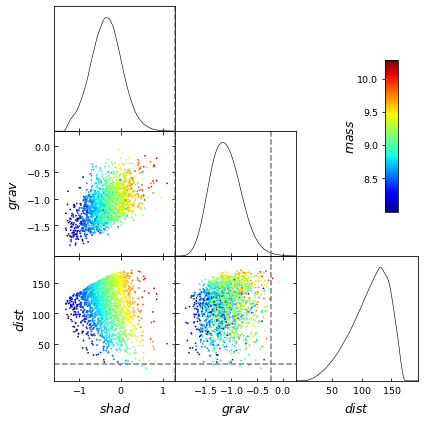

In [324]:
plots.set_active_style();

g = plots.get_subplot_plotter(width_inch=6)

# you can adjust the scaling factor if font sizes are too small when
# making many subplots in a fixed size (default=2 would give smaller fonts)
g.settings.scaling_factor = 1
g.triangle_plot(samples2, ['x2', 'x3','x0'], 
                plot_3d_with_param='x1')

for ax in g.subplots[:,0]:
    ax.axvline(np.log10(19), color='gray', ls='--')
    
for ax in g.subplots[1:,1]:
    ax.axvline(np.log10(qgrav(np.log10(6.5*10**9),16.8)), color='gray', ls='--')
    
for ax in g.subplots[2,:2]:
    ax.axhline(16.8, color='gray', ls='--')


plt.show()
               

In [128]:
1-len(qshadarr[dist_bool][qshadarr[dist_bool]>np.log10(17)])/len(qshadarr[dist_bool])

0.9989864863990718

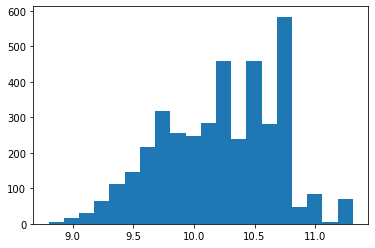

In [127]:
plt.hist(np.tile(mass_new,(rand_N,1))[dist_bool][qshadarr[dist_bool]>np.log10(17)],20)
plt.show()

In [351]:
from scipy.interpolate import UnivariateSpline
intfi=UnivariateSpline(10**bins,np.array([np.sum(Gauss(x,mass_new,dmass_new)) for x in bins])/(intminL(bins)*Vol(z_min,z_max).to(u.Gpc**3).value))
intfi.integral(10**8,10**12)

1259722666139293.5

In [354]:
Phiarr=np.array([np.sum(Gauss(x,mass_new,dmass_new)) for x in bins])/(Vol(z_min,z_max).to(u.Gpc**3).value)
np.trapz(Phiarr*10**(2*bins),10**bins)

2.0387806097511585e+33

In [356]:
Phiarr=np.array([np.sum(Gauss(x,mass_new,dmass_new)) for x in bins])/(Vol(z_min,z_max).to(u.Gpc**3).value)
np.savetxt('arr.txt',Phiarr)

In [357]:
bins

array([ 8.        ,  8.01708543,  8.03417085,  8.05125628,  8.06834171,
        8.08542714,  8.10251256,  8.11959799,  8.13668342,  8.15376884,
        8.17085427,  8.1879397 ,  8.20502513,  8.22211055,  8.23919598,
        8.25628141,  8.27336683,  8.29045226,  8.30753769,  8.32462312,
        8.34170854,  8.35879397,  8.3758794 ,  8.39296482,  8.41005025,
        8.42713568,  8.44422111,  8.46130653,  8.47839196,  8.49547739,
        8.51256281,  8.52964824,  8.54673367,  8.5638191 ,  8.58090452,
        8.59798995,  8.61507538,  8.6321608 ,  8.64924623,  8.66633166,
        8.68341709,  8.70050251,  8.71758794,  8.73467337,  8.75175879,
        8.76884422,  8.78592965,  8.80301508,  8.8201005 ,  8.83718593,
        8.85427136,  8.87135678,  8.88844221,  8.90552764,  8.92261307,
        8.93969849,  8.95678392,  8.97386935,  8.99095477,  9.0080402 ,
        9.02512563,  9.04221106,  9.05929648,  9.07638191,  9.09346734,
        9.11055276,  9.12763819,  9.14472362,  9.16180905,  9.17